# Text classification - computer science papers

The content has been gathered from the popular academic website arXiv.org for articles tagged as computer science content (though some of these are in mathematics or physics categories). The fields are:

• Title the full title <br>
• Abstract : the full abstract <br>
• InformationTheory a "1" if it is classified as an Information Theory article, otherwise "0". <br>
• ComputerVision a "1" if it is classified as a Computer Vision article, otherwise "0". <br>
• ComputationalLinguistics a "1" if it is classified as a Computati onal Linguistic s article, otherwise "0".

The three classes are **ComputationalLinguistics** , **InformationTheory** and **ComputerVision**. These can occur in any combination, so an article could be all three at once, two, one or none. We will build binary classifiers for each of the three classes with permutations for paper title or abstract, two different preprocessing methods, using a sample of the data vs. all of the data, and using a SVM or a vanilla RNN model.

In [17]:
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


## Import libraries

In [ ]:
%matplotlib inline

# Plots
import matplotlib.pyplot as plt

# For pre-processing
import spacy
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# scikit-learn libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,\
 confusion_matrix, precision_recall_curve
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning

# general use
import pandas as pd
import numpy as np
import time
from warnings import simplefilter, filterwarnings
import random
import pickle
from itertools import product, cycle

# For RNN
import torch
from torchtext.legacy import data
from torchtext.legacy.data import TabularDataset
import torch.nn as nn
import torch.optim as optim

First we will create the two versions of text preprocessing (which will also do the tokenizing) as functions, which we will call tokenizer1 and tokenizer2.

### Tokenizers / preprocessing

In [ ]:
# for colab
nltk.download('stopwords')

# Get English stopwords as a list for iteration
stopwordsEnglish = stopwords.words("english")
# Add long dash to punctuation
punctuation = string.punctuation + '–'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Tokenizer 1

The first pre-processing method removes some unwanted punctuation and words with digits in them. It will then lemmatize the tokens, make all tokens lowercase, remove stop words and remove tokens of length less than 3.

In [ ]:
# Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Create custom tokenizer with preprocessing
def tokenizer1(text):

    # Preprocess over characters in each text document    
    # Remove newline text and make lowercase
    text = "".join([x.replace('\n',' ') for x in text])
    # Remove punctuation
    text = "".join([x for x in text if x not in string.punctuation or x == '\''])
    # Remove digits
    text = "".join([x for x in text if not x.isdigit()])
    
    # Preprocess over tokens in each text document
    # Extract the lemma for each token / tokenize text
    text = [token.lemma_ for token in nlp(text)]
    # # Remove stop words    
    text = [x for x in text if x.lower() not in stopwordsEnglish]
    # # Remove words of length less than min_token_length
    text = [x for x in text if len(x)>=3]
    
    return text

#### Tokenizer 2

The second tokenizer removes unwanted punctuation, stems tokens, makes tokens lowercase and removes the same set of stop words.

In [ ]:
# Create stemmer
stemmer = PorterStemmer()

# Create custom tokenizer with preprocessing
def tokenizer2(text):

    # Preprocess over characters in each text document    
    # Remove newline text and make lowercase
    text = "".join([x.replace('\n',' ') for x in text]).lower()
    # Remove punctuation
    text = "".join([x for x in text if x not in string.punctuation or x == '\''])
    
    # Preprocess over tokens in each text document
    # Tokenize
    text = text.split()
    # Stem
    text = [stemmer.stem(x) for x in text]
    # Remove stop words    
    text = [x.lower() for x in text if x.lower() not in stopwordsEnglish]
    
    return text

### Additional Functions

The following additional functions are used to calculate metrics to evaluate classifiers and to and create the macro precision-recall curves. The first is an auxiliary function to assist in calculating macro-averaged precision values by looking up recall values and finding the nearest equivalent precision value. The reason for this is that the arrays returned by sklearn's 'precision_recall_curve' function when calculating for each class were not of the same length so a different method was needed to average out the values.

In [ ]:
# https://stackoverflow.com/questions/38954251/python-find-closest-position-and-value
# Auxiliary function used in calculating values for macro precision-recall curve
def find_nearest(array, value):
    # Lookup value in array and return its index
    index = (np.abs(array-value)).argmin()
    return index

In [ ]:
# Calculate metrics and Precision-Recall Curve values once we have predictions
def calculate_metrics(y_test, y_predict, y_score_1, y_score_0):
    
    # Calculate precision and recall for '1' class label
    precision_1, recall_1, _ = precision_recall_curve(y_test, y_score_1)

    # Calculate precision and recall for '0' class label
    precision_2, recall_2, _ = precision_recall_curve(1 - y_test, y_score_0)
    
    # Create new arrays for macro P-R curve
    recall_macro = np.arange(0,1,1/20000)
    precision_macro = np.array([])

    # Calculate precision values for macro P-R curve
    for i in recall_macro:
        # Use find_nearest function to find index of recall values, used to index precision array
        new_value = \
            (precision_1[find_nearest(recall_1, i)] + precision_2[find_nearest(recall_2, i)]) / 2
        precision_macro = np.append(precision_macro, new_value)
        
    # Calculate metrics
    accuracy = accuracy_score(y_test,y_predict)
    precision = precision_score(y_test,y_predict,average='macro')
    recall = recall_score(y_test,y_predict,average='macro')
    f1 = f1_score(y_test,y_predict,average='macro')
    conf_mat = confusion_matrix(y_test, y_predict).flatten() 
        
    return (recall_macro, precision_macro), accuracy, precision, recall, f1, conf_mat

### Load data

In [ ]:
# Read in the data
df_train = pd.read_csv("./drive/My Drive/Colab Notebooks/train.csv")
df_test = pd.read_csv("./drive/My Drive/Colab Notebooks/test.csv")

# Report the number of documents.
print('Size of training data: {:,}\n'.format(df_train.shape[0]))
print('Size of testing data: {:,}\n'.format(df_test.shape[0]))

# Report proportions of 1 class for each label column in training dataset
print(f'Proportion of 1 class in training data for {df_train.columns[2]} label: \
{df_train.loc[df_train[df_train.columns[2]]==1].shape[0]/df_train.shape[0]}')
print(f'Proportion of 1 class in training data for {df_train.columns[3]} label: \
{df_train.loc[df_train[df_train.columns[3]]==1].shape[0]/df_train.shape[0]}')
print(f'Proportion of 1 class in training data for {df_train.columns[4]} label: \
{df_train.loc[df_train[df_train.columns[4]]==1].shape[0]/df_train.shape[0]}\n')

# Report proportions of 1 class for each label column in testing dataset
print(f'Proportion of 1 class in testing data for {df_test.columns[2]} label: \
{round(df_test.loc[df_test[df_test.columns[2]]==1].shape[0]/df_test.shape[0], 3)}')
print(f'Proportion of 1 class in testing data for {df_test.columns[3]} label: \
{round(df_test.loc[df_test[df_test.columns[3]]==1].shape[0]/df_test.shape[0], 3)}')
print(f'Proportion of 1 class in testing data for {df_test.columns[4]} label: \
{round(df_test.loc[df_test[df_test.columns[4]]==1].shape[0]/df_test.shape[0], 3)}')

Size of training data: 125,000

Size of testing data: 18,066

Proportion of 1 class in training data for InformationTheory label: 0.24
Proportion of 1 class in training data for ComputationalLinguistics label: 0.24
Proportion of 1 class in training data for ComputerVision label: 0.52

Proportion of 1 class in testing data for InformationTheory label: 0.469
Proportion of 1 class in testing data for ComputationalLinguistics label: 0.186
Proportion of 1 class in testing data for ComputerVision label: 0.344


From above we can see that more than half of the training data is classified as 'ComputerVision' with each of the other two labels only holding 24% of the data each. The distribution is different for the testing data.

In [ ]:
# Display the first few rows of data
df_train.head()

,title,abstract,InformationTheory,ComputationalLinguistics,ComputerVision
0,Objective-Dependent Uncertainty Driven Retinal...,From diagnosing neovascular diseases to dete...,0,0,1
1,SMARTies: Sentiment Models for Arabic Target E...,We consider entity-level sentiment analysis ...,0,1,0
2,State-Aware Tracker for Real-Time Video Object...,In this work we address the task of semi-sup...,0,0,1
3,On the Performance of Optimized Dense Device-t...,We consider a D2D wireless network where $n$...,1,0,0
4,Design of Minimum Correlated Maximal Clique Se...,This paper proposes an algorithm to search a...,1,0,0


In [ ]:
# Save first 1,000 cases to be loaded by RNN small training set models
df_train.head(1000).to_csv('./drive/My Drive/Colab Notebooks/train_small.csv', index=False)

### Part 1A: Statistical Method

The statistical method used for this text classification task was a linear support vector machine classifier as this is a good baseline model in many situations and can handle large feature sets. Broadly, it fits a hyperplane in a subspace in such a way so as to maximise the distance between the data points of the two classes. The hyperplane is formed according to the data points closest to the decision boundary, called support vectors, allowing for a certain degree of misclassification.

#### Define functions

Functions for training, testing and returning metrics

In [4]:
# Function to apply a bit of grid search cross validation to tune our hyperparameters
def svm_tuned(train_inputs, train_labels):
    
    parameters = [
    {'penalty':['l2'], 'loss':['squared_hinge', 'hinge'], 'C':[0.1, 0.5, 1, 2, 10], 'dual':[True]},
    {'penalty':['l2'], 'loss':['squared_hinge'], 'C':[0.1, 0.5, 1, 2, 10], 'dual':[False]},
    {'penalty':['l1'], 'loss':['squared_hinge'], 'C':[0.1, 0.5, 1, 2, 10], 'dual':[False]}
    ]

    clf = GridSearchCV(LinearSVC(), parameters)
    clf.fit(train_inputs, train_labels)
    
    print("Best combination of hyperparameters: " + str(clf.best_params_) + '\n')
    
    return clf.best_estimator_

In [5]:
# Call train function and calculate various metrics against test set
def train_and_test(x_train, y_train, x_test, y_test):

    # Tune and fit model with best parameters
    svm = svm_tuned(x_train, y_train)
    # Predict labels with model
    y_predict = svm.predict(x_test)
    
    # Calculate probabilities for '1' label
    y_score_1 = svm._predict_proba_lr(x_test)[:, 1]
    # Calculate probabilities for '0' label
    y_score_0 = svm._predict_proba_lr(x_test)[:, 0]
    
    return calculate_metrics(y_test, y_predict, y_score_1, y_score_0)

#### Prepare data

In [ ]:
# Create vectorizers for all permutations of inputs, dataset size and preprocessing (2*2*2=8)
vectorizers = {}

for i, j , k in product(range(1,3), ["", "Small"], ['Title', 'Abstract']):
    vectorizers[f'vectorizer{k}{j}{str(i)}'] = TfidfVectorizer(analyzer='word',
                                                               input='content',
                                                               min_df = 0.005,
                                                               ngram_range=(1,2),
                                                               tokenizer=vars()['tokenizer'+str(i)])
vectorizers

{'vectorizerAbstract1': TfidfVectorizer(min_df=0.005, ngram_range=(1, 2),
                 tokenizer=<function tokenizer1 at 0x7f1cba279950>),
 'vectorizerAbstract2': TfidfVectorizer(min_df=0.005, ngram_range=(1, 2),
                 tokenizer=<function tokenizer2 at 0x7f1cb642cb90>),
 'vectorizerAbstractSmall1': TfidfVectorizer(min_df=0.005, ngram_range=(1, 2),
                 tokenizer=<function tokenizer1 at 0x7f1cba279950>),
 'vectorizerAbstractSmall2': TfidfVectorizer(min_df=0.005, ngram_range=(1, 2),
                 tokenizer=<function tokenizer2 at 0x7f1cb642cb90>),
 'vectorizerTitle1': TfidfVectorizer(min_df=0.005, ngram_range=(1, 2),
                 tokenizer=<function tokenizer1 at 0x7f1cba279950>),
 'vectorizerTitle2': TfidfVectorizer(min_df=0.005, ngram_range=(1, 2),
                 tokenizer=<function tokenizer2 at 0x7f1cb642cb90>),
 'vectorizerTitleSmall1': TfidfVectorizer(min_df=0.005, ngram_range=(1, 2),
                 tokenizer=<function tokenizer1 at 0x7f1cba279

Below we create a dictionary to store datasets for various configurations of our SVM model then pickle the dictionary so the code does not need to run again.

In [3]:
filterwarnings('ignore', 'SelectableGroups dict interface') # avoid warning in colab

In [ ]:
%%time
datasets_SVM = {}

# Create training and testing datasets (TF-IDF matrix or array) and store in dictionary

# Create 16 datasets for inputs (x) and slice to first 1,000 rows if for training data (small)
# Testing data isn't sliced for small but needs to be scaled based on TrainSmall set
for i, j, k, l in product(range(1,3), ['Title', 'Abstract'], ['Train', 'Test'], ['', 'Small']):

    datasets_SVM[f'x{k}{j}{l}{str(i)}'] = \
        eval(f'vectorizers["vectorizer{j}{l}{str(i)}"].{"fit_" if k=="Train" else ""}transform')(
        eval(f'df_{k.lower()}.{j.lower()}')[:(1000 if k=="Train" and l=="Small" else None)])
    
# Create data labels
for i in ['InformationTheory', 'ComputationalLinguistics', 'ComputerVision']:
    datasets_SVM[f'yTrain{"".join([x for x in i if x.isupper()])}'] = \
        np.asarray(df_train[i].tolist())
    datasets_SVM[f'yTest{"".join([x for x in i if x.isupper()])}'] = \
        np.asarray(df_test[i].tolist())
    datasets_SVM[f'yTrain{"".join([x for x in i if x.isupper()])}Small'] = \
        np.asarray(df_train[i][:1000].tolist())
    
# Save the dictionary
pickle_out = open("./drive/My Drive/Colab Notebooks/svmDataDict.pickle", "wb")
pickle.dump(datasets_SVM, pickle_out)
pickle_out.close()

Wall time: 40min 27s


#### Train models and save metrics

In [ ]:
# Load the dictionary
pickle_in = open("./drive/My Drive/Colab Notebooks/svmDataDict.pickle", "rb")
datasets_SVM = pickle.load(pickle_in)
pickle_in.close()

In [ ]:
# Ignore convergence warning when training/tuning
simplefilter("ignore", category=ConvergenceWarning) 

In [ ]:
# Dictionary to store results
metrics = {'Algorithm':[], 
           'Input':[], 
           'Label':[], 
           'Train_data_size':[], 
           'Preprocessing':[], 
           'Accuracy':[],
           'Precision':[],
           'Recall':[],
           'F1_score':[],
           'TN, FP, FN, TP':[],
          }

# Dictionary to store arrays for macro precision-recall curves
pr_curves = {}

Here, all the SVM models are trained and metrics stored in the dictionaries:

In [ ]:
%%time
# Train all SVM models, test and record performance metrics
label_cols = ['InformationTheory', 'ComputationalLinguistics', 'ComputerVision']
size = ["", "Small"]
input_cols = ['Title', 'Abstract']

for i, j, k, l in product(label_cols, size, input_cols, range(1,3)):
                
    print(f'Binary Classifier: {i}, Input: {k}, Data Size: {"All" if j=="" else "1,000"}, Preprocessing: {l}')
    
    metrics['Algorithm'].append('SVM')
    metrics['Input'].append(k)
    metrics['Label'].append(i)
    metrics['Train_data_size'].append('All' if j=="" else 1000)
    metrics['Preprocessing'].append(l)
    
    # Train model and get metrics
    model_metrics = train_and_test(datasets_SVM[f'xTrain{k}{j}{l}'], 
                                   datasets_SVM[f'yTrain{"".join([x for x in i if x.isupper()])}{j}'], 
                                   datasets_SVM[f'xTest{k}{j}{l}'], 
                                   datasets_SVM[f'yTest{"".join([x for x in i if x.isupper()])}'],
                                  )
    
    # Update metrics dictionary
    metrics['Accuracy'].append(model_metrics[1])
    metrics['Precision'].append(model_metrics[2])    
    metrics['Recall'].append(model_metrics[3])
    metrics['F1_score'].append(model_metrics[4])
    metrics['TN, FP, FN, TP'].append(model_metrics[5])   

    pr_curves[f'SVM{k}{"".join([x for x in i if x.isupper()])}{j}{l}'] = model_metrics[0]

Binary Classifier: InformationTheory, Input: Title, Data Size: All, Preprocessing: 1
Best combination of hyperparameters: {'C': 1, 'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2'}

Binary Classifier: InformationTheory, Input: Title, Data Size: All, Preprocessing: 2
Best combination of hyperparameters: {'C': 10, 'dual': True, 'loss': 'hinge', 'penalty': 'l2'}

Binary Classifier: InformationTheory, Input: Abstract, Data Size: All, Preprocessing: 1
Best combination of hyperparameters: {'C': 0.5, 'dual': True, 'loss': 'hinge', 'penalty': 'l2'}

Binary Classifier: InformationTheory, Input: Abstract, Data Size: All, Preprocessing: 2
Best combination of hyperparameters: {'C': 1, 'dual': True, 'loss': 'hinge', 'penalty': 'l2'}

Binary Classifier: InformationTheory, Input: Title, Data Size: 1,000, Preprocessing: 1
Best combination of hyperparameters: {'C': 1, 'dual': True, 'loss': 'hinge', 'penalty': 'l2'}

Binary Classifier: InformationTheory, Input: Title, Data Size: 1,000, Preprocessi

In [ ]:
# Save
pickle_out = open("./drive/My Drive/Colab Notebooks/pr_curves.pickle", "wb")
pickle.dump(pr_curves, pickle_out)
pickle_out.close()

In [ ]:
# Save
pickle_out = open("./drive/My Drive/Colab Notebooks/metrics.pickle", "wb")
pickle.dump(metrics, pickle_out)
pickle_out.close()

### Part 1B: RNN Method

RNNs are good for modelling sequence data such as text data. The inputs (word tokens) are fed through the network sequentially together with the latest representation of all previous words, called the hidden state, an encoded representation of previous word tokens in the sequence. The final hidden state contains encodings of all words in the sequence and can be passed to the linear layer, from which predictions can be made.

#### Define functions

In [ ]:
# Create RNN class from nn.Module
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()

        # Define layers
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    # Define forward pass method: text -> embedding -> output and hidden
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

In [ ]:
# Compares predictions to ground truth and returns accuracy between 0 and 1
def binary_accuracy(preds, y):

    rounded_preds = torch.round(torch.sigmoid(preds)) # apply sigmoid and round values to 0 or 1
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
# Function to train RNN
def train(model, iterator, optimizer, criterion, inputCol, outputCol):
    
    epoch_loss = 0
    epoch_acc = 0
    
    # Put model in training mode
    model.train()
    
    for batch in iterator:
        
        # Reset gradient / prevent accumulation of gradients across batches
        optimizer.zero_grad()
                
        # Feed batches of inputs to the model
        predictions = model(eval(f'batch.{inputCol}')).squeeze(1)
        
        # Use labels and loss creterion to calculate loss
        loss = criterion(predictions, eval(f'batch.{outputCol}'))     
        
        # Calculate accuracy
        acc = binary_accuracy(predictions, eval(f'batch.{outputCol}'))
        
        # Perform backpropogation
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Track loss and accuracy
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
# For calculation of loss and accuracy on validation step
def evaluate(model, iterator, criterion, inputCol, outputCol):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(eval(f'batch.{inputCol}')).squeeze(1)

            loss = criterion(predictions, eval(f'batch.{outputCol}'))     

            acc = binary_accuracy(predictions, eval(f'batch.{outputCol}'))

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
# To track epoch time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# Returns number of parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
# Use test data to get predictions and y_scores for precision-recall curves
def get_predictions(model, iterator, inputsCol, labelsCol):
    
    y_predict = []
    y_test = []
    y_score_1 = []

    # Get label predictions and truth
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            predictions = model(eval(f'batch.{inputsCol}')).squeeze(1) # model prediction raw values
            y_prob = torch.sigmoid(predictions) # Return predictions bounded to between 0 & 1
            rounded_preds = torch.round(y_prob) # Round all sigmoid values to 0 or 1
            y_predict += rounded_preds.tolist() # Add batch's predictions to list
            y_score_1 += y_prob.tolist() # Add probabilities to list for class 1
            y_test += eval(f'batch.{labelsCol}').tolist() # Build list of test data

        # Convert lists to numpy arrays
        y_score_1 = np.asarray(y_score_1)
        y_score_0 = 1 - y_score_1 # Get y probabilities for class 0 using class 1 probabilities
        y_test = np.asarray(y_test)
        y_predict = np.asarray(y_predict)

    return y_test, y_predict, y_score_1, y_score_0

#### Create data and vocabulary

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Create data fields
text_title_1 = data.Field(sequential=True, tokenize = tokenizer1, 
                          tokenizer_language = 'en_core_web_sm')
text_abstract_1 = data.Field(sequential=True, tokenize = tokenizer1, 
                             tokenizer_language = 'en_core_web_sm')
text_title_small_1 = data.Field(sequential=True, tokenize = tokenizer1, 
                                tokenizer_language = 'en_core_web_sm')
text_abstract_small_1 = data.Field(sequential=True, tokenize = tokenizer1, 
                                   tokenizer_language = 'en_core_web_sm')
text_title_2 = data.Field(sequential=True, tokenize = tokenizer2, 
                          tokenizer_language = 'en_core_web_sm')
text_abstract_2 = data.Field(sequential=True, tokenize = tokenizer2, 
                             tokenizer_language = 'en_core_web_sm')
text_title_small_2 = data.Field(sequential=True, tokenize = tokenizer2, 
                                tokenizer_language = 'en_core_web_sm')
text_abstract_small_2 = data.Field(sequential=True, tokenize = tokenizer2, 
                                   tokenizer_language = 'en_core_web_sm')
label = data.LabelField(dtype = torch.float, use_vocab=False, preprocessing=int)

In [ ]:
%%time

# Create datasets
datasets_RNN = {}
    
for i, j in product(range(1,3), ["", "_small"]):

    datafields = [("title", vars()[f'text_title{j}_{i}']),
                        ("abstract", vars()[f'text_abstract{j}_{i}']),
                        ("InformationTheory", label),
                        ("ComputationalLinguistics", label),
                        ("ComputerVision", label)]

    train_data_unsplit, test_data = TabularDataset.splits(path='./drive/My Drive/Colab Notebooks',
                                                        train=f'train{j}.csv',
                                                        test='test.csv', 
                                                        format='csv', 
                                                        skip_header=True, 
                                                        fields=datafields)

    # Split training data into train and validation sets
    train_data, valid_data = train_data_unsplit.split(split_ratio=0.7)

    datasets_RNN[f'train_data{j}_{i}'] = train_data
    datasets_RNN[f'valid_data{j}_{i}'] = valid_data
    datasets_RNN[f'test_data{j}_{i}'] = test_data

CPU times: user 38min 39s, sys: 14.2 s, total: 38min 53s
Wall time: 38min 47s


In [ ]:
# Check dataset sizes
for x, y, z in product(['train', 'valid', 'test'], ["", "_small"], range(1,3)):
    print(f'Number of {x} {z}{" " + "".join(filter(str.isalnum, y)) if y else y} examples: ' \
          + str(len(eval(f'datasets_RNN["{x}_data{y}_{str(z)}"]'))))

Number of train 1 examples: 87500
Number of train 2 examples: 87500
Number of train 1 small examples: 700
Number of train 2 small examples: 700
Number of valid 1 examples: 37500
Number of valid 2 examples: 37500
Number of valid 1 small examples: 300
Number of valid 2 small examples: 300
Number of test 1 examples: 18066
Number of test 2 examples: 18066
Number of test 1 small examples: 18066
Number of test 2 small examples: 18066


In [ ]:
# Build vocabs
for x, y, z in product(['title', 'abstract'], ["", "_small"], range(1,3)):
    eval(f'text_{x}{y}_{str(z)}\
        .build_vocab(datasets_RNN["train_data{y}_{str(z)}"],\
        min_freq = len(datasets_RNN["train_data{y}_{str(z)}"])*0.005)')

    # Check length of vocabularies
    print(f'Unique tokens in {x} text {str(z)}{" " + "".join(filter(str.isalnum, y)) if y else y} '\
         + f'vocabulary: ' + str(len(eval(f'text_{x}{y}_{str(z)}.vocab'))))

Unique tokens in title text 1 vocabulary: 254
Unique tokens in title text 2 vocabulary: 283
Unique tokens in title text 1 small vocabulary: 267
Unique tokens in title text 2 small vocabulary: 296
Unique tokens in abstract text 1 vocabulary: 2310
Unique tokens in abstract text 2 vocabulary: 2104
Unique tokens in abstract text 1 small vocabulary: 2534
Unique tokens in abstract text 2 small vocabulary: 2350


#### Train models and save metrics

In [ ]:
# Load the metrics and PR curve dictionaries
pickle_in = open("./drive/My Drive/Colab Notebooks/metrics.pickle", "rb")
metrics = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("./drive/My Drive/Colab Notebooks/pr_curves.pickle", "rb")
pr_curves = pickle.load(pickle_in)
pickle_in.close()

Below, the settings for the RNNs is chosen and the code iterates over all 24 permuations of configurations to create 24 models, calculating metrics and arrays for macro precision-recall curves. For each epoch, training and validation loss and accuracy is printed in the output to see if the model is learning. The batch size of 4 and the learning rate of 0.005 with 20 epochs was found to be a reasonable compromise of training time and performance.

In [ ]:
%%time

# Allow for use of colab gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Configure for all 24 RNNs
N_EPOCHS = 20
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
BATCH_SIZE = 4
LEARNING_RATE = 5e-3

# Choose binary cross entropy for loss calculation
criterion = nn.BCEWithLogitsLoss().to(device)

# Configurations to iterate through
label_cols = ['InformationTheory', 'ComputationalLinguistics', 'ComputerVision']
input_cols = ['title', 'abstract']
size = ["", "Small"]

# Iterate over configurations to create 24 RNN models, get predictions and calculate metrics
for i, j, k, l in product(label_cols, input_cols, size, range(1,3)):

    # Save down details of current model
    metrics['Algorithm'].append('RNN')
    metrics['Input'].append(j.title())
    metrics['Label'].append(i)
    metrics['Train_data_size'].append('All' if k=="" else 1000)
    metrics['Preprocessing'].append(l)

    # Set input dimension, which depends on the vocabulary 
    INPUT_DIM = len(eval(f'text_{j}{k if k=="" else "_small"}_{l}.vocab'))

    # Initialise model
    model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

    # Display model configuration and number of parameters
    print(f'\nModel {j.title()} {i} {"All" if k=="" else k} {l} has ' \
        + f'{count_parameters(model):,} trainable parameters \n')

    # Create optimizer using stochastic gradient descent
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

    # Put model to gpu if possible
    model = model.to(device)

    # Create iterators
    train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
        (datasets_RNN[f'train_data{"_" + k.lower() if k else k}_{l}'], 
         datasets_RNN[f'valid_data{"_" + k.lower() if k else k}_{l}'], 
         datasets_RNN[f'test_data{"_" + k.lower() if k else k}_{l}']
         ),
        batch_size = BATCH_SIZE,
        device = device,
        sort_key = lambda x: len(eval(f'batch.{j}')),
        sort_within_batch = False)

    batch = next(train_iterator.__iter__())

    # Initialise starting validation loss
    best_valid_loss = float('inf')

    # Run training/evaluation of the model N_EPOCHS times
    for epoch in range(N_EPOCHS):

        start_time = time.time()
        
        # Calculate train/valid loss/acc
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion, j, i)
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, j, i)
        
        end_time = time.time()

        # Calculate epoch elapsed time
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # If validation loss drops, current model is best, overwrite
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(),
                         f'./drive/My Drive/Colab Notebooks/\RNN_model_{j}{k if k=="" else "_small"}_{"".join([x for x in i if x.isupper()])}_{l}.pt'
                        )
        
        # Display epoch data
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    # Get test, predictions and y_scores as arrays
    y_values = get_predictions(model, test_iterator, j, i)

    # Train model and get metrics
    model_metrics = calculate_metrics(y_values[0], y_values[1], y_values[2], y_values[3])
    
    # Update metrics dictionary
    metrics['Accuracy'].append(model_metrics[1])
    metrics['Precision'].append(model_metrics[2])    
    metrics['Recall'].append(model_metrics[3])
    metrics['F1_score'].append(model_metrics[4])
    metrics['TN, FP, FN, TP'].append(model_metrics[5])   

    # Add macro precision and recall arrays to dict
    pr_curves[f'RNN{j.title()}{"".join([x for x in i if x.isupper()])}{k}{l}'] = model_metrics[0]


Model Title InformationTheory All 1 has 117,305 trainable parameters 

Epoch: 01 | Epoch Time: 1m 15s
	Train Loss: 0.312 | Train Acc: 86.41%
	 Val. Loss: 0.252 |  Val. Acc: 88.40%
Epoch: 02 | Epoch Time: 1m 14s
	Train Loss: 0.208 | Train Acc: 91.35%
	 Val. Loss: 0.181 |  Val. Acc: 92.56%
Epoch: 03 | Epoch Time: 1m 14s
	Train Loss: 0.185 | Train Acc: 92.37%
	 Val. Loss: 0.185 |  Val. Acc: 92.28%
Epoch: 04 | Epoch Time: 1m 14s
	Train Loss: 0.175 | Train Acc: 92.84%
	 Val. Loss: 0.166 |  Val. Acc: 93.06%
Epoch: 05 | Epoch Time: 1m 13s
	Train Loss: 0.168 | Train Acc: 93.02%
	 Val. Loss: 0.179 |  Val. Acc: 92.70%
Epoch: 06 | Epoch Time: 1m 13s
	Train Loss: 0.164 | Train Acc: 93.24%
	 Val. Loss: 0.164 |  Val. Acc: 93.22%
Epoch: 07 | Epoch Time: 1m 13s
	Train Loss: 0.160 | Train Acc: 93.42%
	 Val. Loss: 0.177 |  Val. Acc: 92.78%
Epoch: 08 | Epoch Time: 1m 13s
	Train Loss: 0.158 | Train Acc: 93.50%
	 Val. Loss: 0.165 |  Val. Acc: 93.26%
Epoch: 09 | Epoch Time: 1m 13s
	Train Loss: 0.155 | Trai

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Model Abstract ComputationalLinguistics Small 1 has 345,305 trainable parameters 

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 0.588 | Train Acc: 72.71%
	 Val. Loss: 0.595 |  Val. Acc: 74.67%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 0.576 | Train Acc: 75.14%
	 Val. Loss: 0.583 |  Val. Acc: 74.33%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 0.567 | Train Acc: 75.29%
	 Val. Loss: 0.568 |  Val. Acc: 74.33%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.557 | Train Acc: 76.29%
	 Val. Loss: 0.563 |  Val. Acc: 75.00%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.551 | Train Acc: 76.43%
	 Val. Loss: 0.585 |  Val. Acc: 75.00%
Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 0.549 | Train Acc: 76.43%
	 Val. Loss: 0.552 |  Val. Acc: 75.33%
Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 0.551 | Train Acc: 76.43%
	 Val. Loss: 0.552 |  Val. Acc: 75.33%
Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 0.542 | Train Acc: 76.71%
	 Val. Loss: 0.553 |  Val. Acc: 75.33%
Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 0.535 | T

In [ ]:
# Save metrics
pickle_out = open("./drive/My Drive/Colab Notebooks/metrics_all.pickle", "wb")
pickle.dump(metrics, pickle_out)
pickle_out.close()

# Save PR curves
pickle_out = open("./drive/My Drive/Colab Notebooks/pr_curves_all.pickle", "wb")
pickle.dump(pr_curves, pickle_out)
pickle_out.close()

### Part 1C:  Results for Methods

All metrics (accuracy, macro precision, macro recall, macro F1 as well as each confusion matrix) are loaded from the dictionary and converted to a dataframe.

In [ ]:
# Load the metrics dictionary
pickle_in = open("./drive/My Drive/Colab Notebooks/metrics_all.pickle", "rb")
metrics_all = pickle.load(pickle_in)
pickle_in.close()

In [ ]:
# Load metrics into a DataFrame
metrics_df = pd.DataFrame.from_dict(metrics_all)
metrics_df

,Algorithm,Input,Label,Train_data_size,Preprocessing,Accuracy,Precision,Recall,F1_score,"TN, FP, FN, TP"
0,SVM,Title,InformationTheory,All,1,0.868372,0.884633,0.862088,0.865118,"[9247, 340, 2038, 6441]"
1,SVM,Title,InformationTheory,All,2,0.881435,0.893791,0.876094,0.879036,"[9234, 353, 1789, 6690]"
2,SVM,Abstract,InformationTheory,All,1,0.959537,0.961891,0.957827,0.959231,"[9450, 137, 594, 7885]"
3,SVM,Abstract,InformationTheory,All,2,0.958596,0.961230,0.956763,0.958269,"[9459, 128, 620, 7859]"
4,SVM,Title,InformationTheory,1000,1,0.823038,0.857853,0.813247,0.814914,"[9327, 260, 2937, 5542]"
5,SVM,Title,InformationTheory,1000,2,0.839201,0.860582,0.831564,0.834089,"[9166, 421, 2484, 5995]"
6,SVM,Abstract,InformationTheory,1000,1,0.933522,0.941156,0.929900,0.932614,"[9481, 106, 1095, 7384]"
7,SVM,Abstract,InformationTheory,1000,2,0.935404,0.941754,0.932137,0.934606,"[9447, 140, 1027, 7452]"
8,SVM,Title,ComputationalLinguistics,All,1,0.892339,0.845872,0.774537,0.802921,"[14145, 553, 1392, 1976]"
9,SVM,Title,ComputationalLinguistics,All,2,0.901030,0.860517,0.793038,0.820611,"[14187, 511, 1277, 2091]"


### Part 1D: Plots for Methods

In [ ]:
# Load the metrics and PR curve dictionaries
pickle_in = open("./drive/My Drive/Colab Notebooks/pr_curves_all.pickle", "rb")
pr_curves_all = pickle.load(pickle_in)
pickle_in.close()

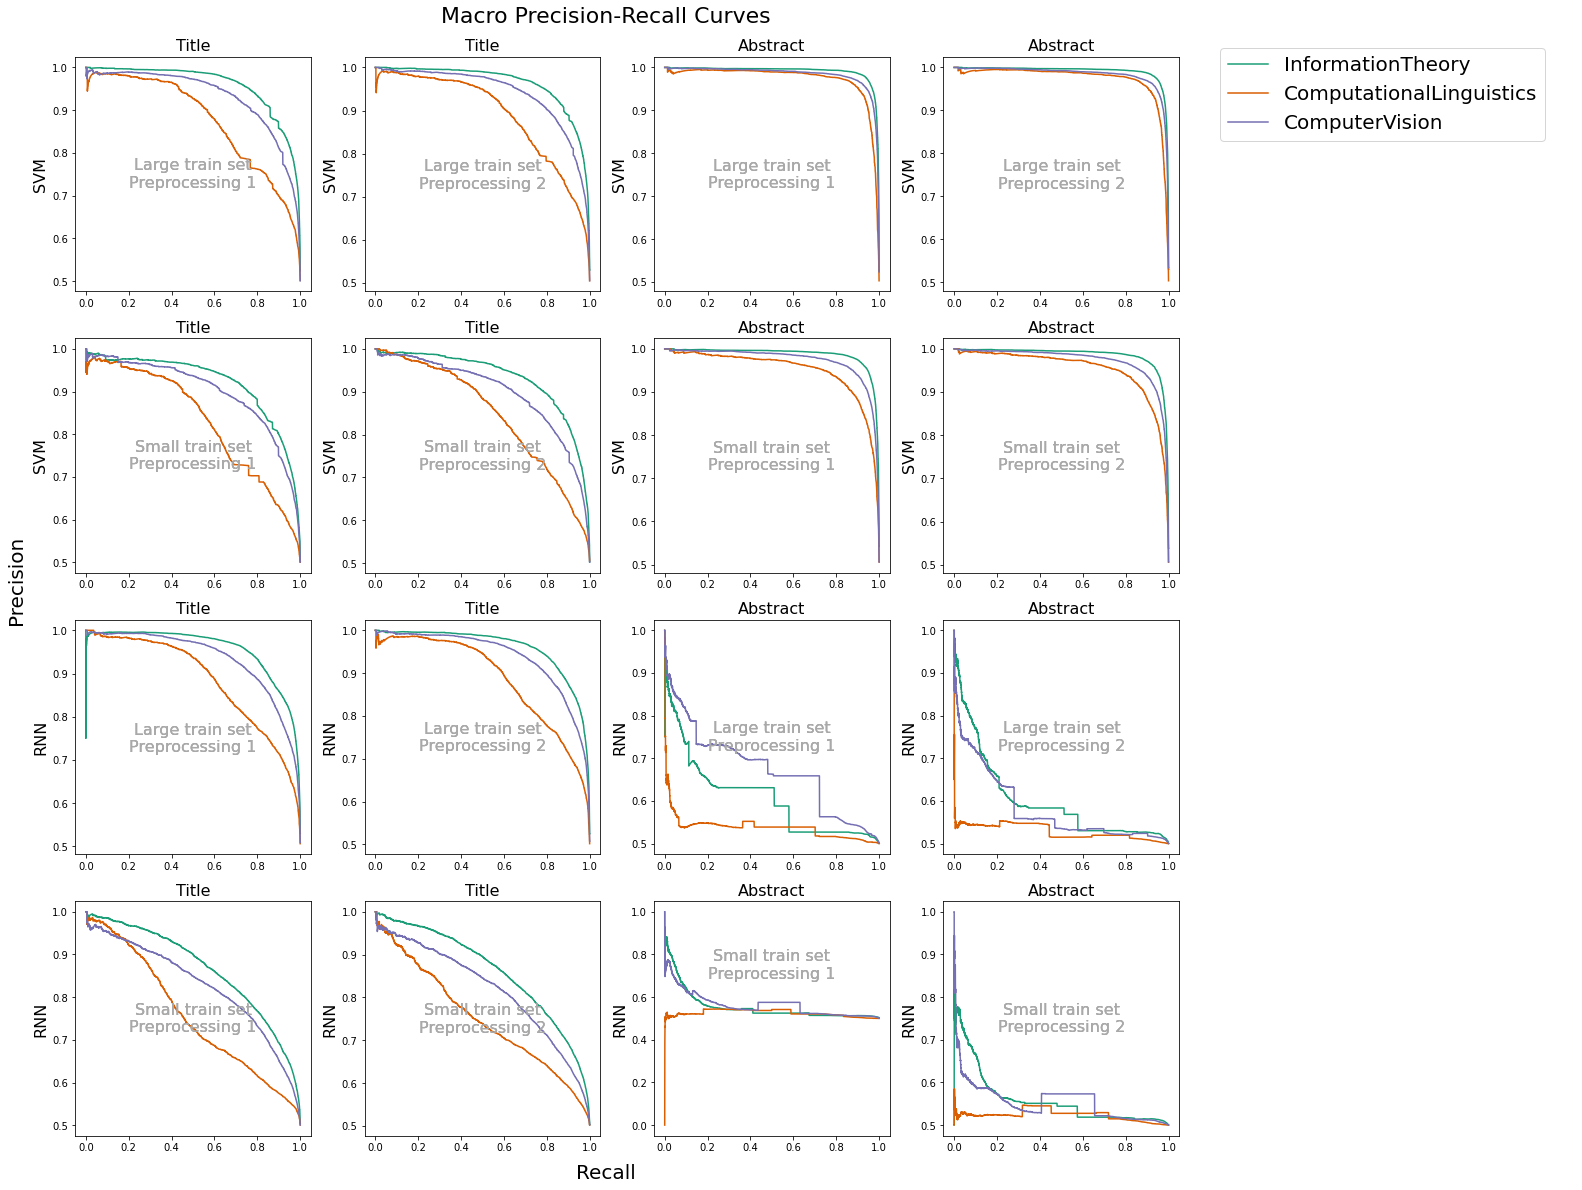

In [ ]:
# Create subplots
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(16, 16), constrained_layout=True)

# Add heading and axis labels
fig.suptitle('Macro Precision-Recall Curves', fontsize=22)
fig.text(0.5, -0.02, s='Recall', ha='center', fontsize=20)
fig.text(-0.02, 0.5, s='Precision', va='center', rotation='vertical', fontsize=20)

# Configurations
algorithm = ['SVM', 'SVM', 'RNN', 'RNN']
input_cols = ['Title', 'Title', 'Abstract', 'Abstract']
size = ["", "Small"]
bin_clf = [('IT', 'InformationTheory'), ('CL', 'ComputationalLinguistics'), ('CV', 'ComputerVision')]
rows = range(4); cols = range(4)
hues = ['#1b9e77', '#d95f02', '#7570b3']

# Iterate over permutations
for (a, s, r), (i, p, c), (b, h) in product(
    zip(algorithm, cycle(size), rows), 
    zip(input_cols, cycle(range(1,3)), cols), 
    zip(bin_clf, hues)):

    # Plot, label subplot and add centre annotation
    model_name = f'{a}{i}{b[0]}{s}{p}'
    axs[r, c].plot(pr_curves_all[model_name][0], pr_curves_all[model_name][1], color=h, label=b[1])
    axs[r, c].set_title(i, fontsize=16)
    axs[r, c].set_ylabel(a, fontsize=16)
    axs[r, c].annotate(f'{s if s else "Large"} train set\nPreprocessing {p}', (0.5, 0.75),
                            transform=axs[r, c].transAxes,
                            ha='center', va='center', fontsize=16,
                            color='darkgrey')

# https://stackoverflow.com/questions/9834452/how-do-i-make-a-single-legend-for-many-subplots-with-matplotlib
# Add legend
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(x, []) for x in zip(*lines_labels)]
fig.legend(lines, list(set(labels)), prop={'size': 20}, bbox_to_anchor=(1.05, 1), loc='upper right')

### Comparison of algorithms, input types and dataset sizes
Overall, the linear support vector classifier models performed better than the recurrent neural network classifier models and were usually much faster to train too. This was especially obvious for the models that used the abstracts of the articles rather than the titles, most of which returned metrics above 90% across the board (accuracy, macro precision/recall/f1-score) for SVM with the lowest still being above 89%. This can also be seen by the macro precision-recall curves in part 1D of the notebook file in the upper right quadrant, which shows little trade-off between macro precision and macro recall.

On the other hand, the RNN models trained on abstracts learned very little if anything at all. The precision-recall curves show very poor performance with little gain in precision as the recall drops away, unless recall is a very low value. Furthermore, the accuracy scores from the table of results suggest that most of these models had a high rate of predicting the negative class (i.e., to not classify each document as the label being trained on). This is why accuracy is above 80% for the Computational Linguistics classifiers, which had over 80% of test data being the negative class. They all performed much more poorly when using any of the other metrics, which were boosted by being macro-averaged. Most of the other RNN models trained and tested on the abstracts of documents also had accuracy scores similar to the percentage of negative labels from the test data.

For the models trained and tested on titles instead, the two algorithms performed much more similarly, better than the RNN models trained using abstracts but not as well as the SVM models trained using abstracts. In particular, the two algorithms were very similar when using the entire dataset for training, where the metrics were, on average, in the mid-80s. When only 1,000 documents were used in training, the SVM models performed consistently better than the RNN models as can be seen by visually inspecting the precision-recall curves of the respective sets of classifiers, although the difference is not as pronounced as with abstracts. The metrics are also notably higher for SVM than RNN in every case when the smaller dataset is used. This suggests that the RNN models require more data than the SVM models to improve their performance although the SVM title models also performed better with all the data than with only 1,000 rows. This also extended to the models trained on abstracts – the performance improved with the larger datasets with the exception of the RNN model for Computer Vision using pre-processing method 2, which only had an accuracy of 52.5% and an F1-score of 51.8%, perhaps due to a poor initialisation of weights.

The poor performance of the RNNs when using the abstracts is likely due to the issue of vanishing gradients when optimising the models through backpropagation. Unlike when using titles, which are much shorter sequences of data, the abstracts are much longer. The effects of backpropagation to update the weights in the network will have little to no effect on a large portion of the words in the sequence so the network is only learning from words near the end of each abstract. An alternative RNN architecture such as LSTM could improve the model by resolving the short-term memory issue.

### Comparison of pre-processing methods
The two pre-processing methods shared a number of steps, being the removal of unwanted characters, stop words and making all word tokens lowercase. The first method also removed tokens with digits in them, tokens with less than 3 characters and used spacy lemmatization while the second method used did not include those additional steps but used the porter stemmer instead. No noticeable differences or patterns emerged in the output of metrics or plots between the two methods of pre-processing, with the exception of the RNN abstract models, which all performed very poorly and were likely susceptible to random initialisation of weights. The implication would be that the two methods of pre-processing did not turn out to be materially different. The first method of pre-processing took longer due to the spacy lemmatization but as it did not appear to result in better performing models, it was probably an unnecessary step.

### Comparison of binary classifiers
Most of the computational linguistics (CL) and information theory (IT) classifiers produced more false negatives than false positives while computer vision (CV) classifiers produced more false positives than false negatives. This could have been as a result of the distribution of labels in the training set where CV labels were more prevalent compared to CL and IT labels. In the distribution of labels in the testing set, IT labels were much more prevalent while CV labels were scaled down a bit.
The CL classifiers tended to have higher accuracies than the other two classifiers due to the class imbalance in the testing set, with over 80% belonging to the negative class. Proportionally, they did not perform as well at classifying the positive class correctly or recalling instances of the positive class. However, due to macro averaging with the negative class they could still produce some reasonable macro precision, recall and F1 scores, although they were almost always weaker than the same metrics for the equivalent IT models and generally also the CV models. The IT classifiers generally performed better than the CV classifiers.

The RNN abstract IT and CL models produced a number of notable low macro F1-scores, often lower than both of their macro precision and recall scores. This would happen when at least one of the binary precision or recall metrics were very low, which, due to the multiplication of precision and recall in the numerator of the F1-score formula would result in a very low binary F1-score. For example, the RNN abstract model for IT classifier using 1,000 rows of data and pre-processing method 2 had 177 true positives and 8,302 false negatives meaning only around 2% of positive labels were being recalled. This resulted in an extremely poor binary F1-score for the true label, which is macro averaged up to 0.3679 due to the negative class not performing as poorly and therefore having a much greater binary F1-score.

The overall trend from the macro precision-recall plots shows that the IT classifiers performed the best across macro precision and recall as they had the greatest area under their macro-precision curves, which tells us that there is less of a trade-off between the two metrics (i.e., we don’t have to reduce one by as much to improve the other). CL classifiers performed the worst. Overall, across all models on average, precision was a bit higher than recall telling us that the models were a bit more conservative when predicting a class. The SVM title CL classifiers are an example of this – there were fewer true positive and more false negatives compared to some of the better models. This had a greater impact on recall than precision and due to the imbalance of positive and negative CL labels, it didn’t have as proportionally great of an effect on the precision of the negative class either.

### Summary

From the metrics and the precision-recall curves, the best models were SVM Information Theory classifiers, trained using the abstract, all of the data and either of the pre-processing methods, which produced the highest macro precision, recall and F1-scores while the Computational Linguistics classifiers trained with the same configurations produced the best accuracy scores. The worst models were RNNs trained with abstracts, due to the vanishing gradient effect.